# Proyecto: Clasificación múltiple usando Redes Neuronales

## En el presente proyecto se muestra un problema de clasificación múltiple con redes neuronales donde la capa de salida tiene múltiples neurona.

## La función de activación en la capa de salida es del tipo `activation = softmax` 

## dado que codificamos las etiquetas con `to_categorical` usaremos la función de costo es del tipo `loss = categorical_crossentropy`

## Usaremos técnicas para reducir "overfitting" mediante:

## * Regularización (con normas $L_{1}$ y $L_{2}$)

## * DropOut (reducción del porcentaje de neuronas a activar en cada capa)

## Trabajaremos con el dataset "reuters" de Keras que corresponde a reseñas (comentarios) que son de 46 Clases distintas (clasificación múltiple)

In [1]:
import numpy as np

# importamos funciones para construir redes neuronales:
from tensorflow.keras import layers, models, optimizers, regularizers

from keras.datasets import reuters

# Librería para separar datos:
from sklearn.model_selection import train_test_split

# función para codificar variables
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt


In [2]:
# Cargamos datos:

# Maximo numero de palabras en cada mensaje
N = 10000

(features_train , labels_train),(features_test , labels_test) = reuters.load_data(num_words=N)

# Diccionario {'palabra':numero} correspondiente al dataset 'reuters'
dict_word_index = reuters.get_word_index()

# Los 'features' son arreglos cuyos elementos son listas de la forma:
# feature[i] = [n0,n1,...,nk] donde cada número 'ni' corresponde a una palabla
# cuyo valor se decodifica con el diccionario 'dict_word_index'.
# Así que cada lista 'feature[i]' representa un comentario.
#  
# El valor de cada 'label' es un número entero entre 0 y 45, que representa alguna de las
# 46 clasificaciones que puede tomar el 'feature' (comentario) correspondiente.

/home/marck/.local/lib/python3.8/site-packages/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/marck/.local/lib/python3.8/site-packages/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


## Exploramos los datos:

In [3]:
# Exploramos datos:

print('El dataset "features_train" es de tamaño:' , features_train.shape)
print('El dataset "features_test" es de tamaño:' , features_test.shape)
print('Cada elemento de "features" es de tipo:' , type(features_train[0]))

print('\nEl dataset "labels_train" es de tamaño:' , labels_train.shape)
print('El dataset "labels_test" es de tamaño:' , labels_test.shape)
print('Cada elemento de "labels" es de tipo:' , type(labels_train[0]))

El dataset "features_train" es de tamaño: (8982,)
El dataset "features_test" es de tamaño: (2246,)
Cada elemento de "features" es de tipo: <class 'list'>

El dataset "labels_train" es de tamaño: (8982,)
El dataset "labels_test" es de tamaño: (2246,)
Cada elemento de "labels" es de tipo: <class 'numpy.int64'>


### De la información anterior podemos saber que cada "feature" es una lista (correspondiente a la codificación numérica de un mensaje)
### cada "label" es un numero entero del tipo: `numpy.int64`

In [4]:
# Si queremos ver el contenido de un mensaje debemos decodificarlo con el diccionario 'get_word_index()'
# como se mestra a continuación:

# seleccionmos un mensaje (k < 8982)
k = 15

numeric_message = features_train[k] # <--- k-esimo mensaje codificado con números

# Cambiamos el diccionario a la forma {numero:'palabra'}:
dict_index_word = dict( [ (value,key) for key,value in dict_word_index.items() ] )

# Decodificamos el k-esimo mensaje:
#for n in numeric_message:
#    # decodificamos el contenido usando el diccionario 'word_index':
#    print( dict_index_word.get(n-3) )

In [5]:
# Extraemos las clases totales de las etiquetas del dataset:
clases = np.unique(labels_train)
n_clases = len(clases)

print('Hay',n_clases,'clases posibles para las etiquetas')
print('Clases:\n',clases)

Hay 46 clases posibles para las etiquetas
Clases:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


## Codificamos features y labels para entrenar la red:

In [6]:
# A continuación creamos una funcón para codificar 
# los features como arreglos con entradas son binarias 

# Por ejemplo, 
# si 'feature' = [0,2,4] enconces,
# 'enoded_feature' = [1,0,1,0,1,0,0,0,0,...,0]
# 'enoded_feature' tiene '1' solamente en los índices dados en 'feature'

# Función que codifica los features con entradas binarias:
def features_encoder(features, dim=N):
    n_sentense = len(features)

    # Inicializamos arreglo con ceros:
    binary_features = np.zeros( (n_sentense, dim) )
    
    for i in range(n_sentense):
        for j in features[i]:
            # Vamos poniendo unos en los indices que indica 'features[i]'
            binary_features[i,j]=1
                
    return binary_features

In [7]:
# Aplicamos nuestra función para codificar los features:
x_train = features_encoder(features_train,dim=N)
x_test = features_encoder(features_test,dim=N)

In [8]:
# Anteriormente vimos que hay 46 etiquetas distintas 'clases = [0 1 2 3 ... 45]'

# Debido a que entrenaremos la red usando la función de costo `loss='categorical_crossentropy'`

# debemos codificar los labels como vectores de datos categóricos:
# - 0 --> [1, 0, 0, 0, 0, 0, 0, 0,..., 0]
# - 1 --> [0, 1, 0, 0, 0, 0, 0, 0,..., 0]
# - 2 --> [0, 0, 1, 0, 0, 0, 0, 0,..., 0]
# - 
# -
# -45 --> [0, 0, 0, 0, 0, 0, 0, 0,..., 1]

# Además debemos recordar que los valores de la función de activación en la capa de salida arrojará valores: {0,1}

y_train = to_categorical(labels_train)
y_test = to_categorical(labels_test)

In [9]:
# Particionamos el conjunto de entrenamiento original 
# en nuevos subconjuntos de entrenamiento y validación:

p_train=0.75  # porcentaje para datos de entrenamiento
p_validation=0.25 # porcentaje  para datos de validación

x_train_part, x_validation, y_train_part, y_validation = train_test_split (x_train, y_train, train_size=p_train, test_size=p_validation, random_state=42)

print('Hay',len(x_train_part),'datos para entrenamiento y',len(x_validation),'datos para validación')

Hay 6736 datos para entrenamiento y 2246 datos para validación


In [10]:
# dimensión de los features para entrenar la red:
dim_feature = x_train_part[0].shape
dim_feature

(10000,)

## Creamos la arquitectura de la Red Neuronal:

In [106]:
# Creamos red neuronal:

# ================= Paraetros que controlan la convergencia de la red =====================

n_epochs = 20 # <-- iteraciones de forward y backward propagations
n_batch_size = 200

nn1 = 70 # <-- numero de neuronas para la capa 1
nn2 = 100  # <-- numero de neuronas de la capa 2
nn_out = n_clases  # <-- numero de neuronas de la capa de salida

p_active = 0.5 #<-- porcentaje de neuronas a activar aleatoriamente en las capas con dropout

alfa_l1 = 0.01 # <-- multiplo del regularizador l1
alfa_l2 = 0.01 # <-- multiplo del regularizador l2
# kernel_regularizer=regularizers.l1_l2(alfa_l1, alfa_l2)

# learning rate para el optimizador:
lr=0.001

# ===========================================================================================

# INICIALIZAMOS RED
model = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
model.add( layers.Dense(nn1 ,activation='relu', input_shape =dim_feature ) )# <-- capa 1 (Recibe features)
#model.add( layers.Dropout(p_active) ) # hacemos "dropout" a la capa anterior
model.add( layers.Dense(nn2, activation='relu' , kernel_regularizer=regularizers.l1_l2(alfa_l1, alfa_l2) ) ) # <-- capa 2
model.add( layers.Dropout(p_active) ) # hacemos "dropout" a la capa anterior
model.add( layers.Dense(nn_out, activation='softmax') )#<-- capa de salida (Arroja labels predichos)

In [107]:
# visualzamos la arquitecura de la red:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 70)                700070    
_________________________________________________________________
dense_31 (Dense)             (None, 100)               7100      
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 46)                4646      
Total params: 711,816
Trainable params: 711,816
Non-trainable params: 0
_________________________________________________________________


In [108]:
# compilamos la red:

# optimizador:
optim_meth = optimizers.Nadam(learning_rate=lr)

model.compile(
    optimizer= optim_meth, # <--- Elegimos el método de optmimización,
    loss='categorical_crossentropy',# <-- función de costo recomendada para clasificación no binaria
    metrics='accuracy'
    )

In [109]:
# Entrenemos el modelo y los resultados los guardamos en 'history':
results = model.fit(
    x_train_part, 
    y_train_part,
    epochs=n_epochs,
    batch_size=n_batch_size,
    validation_data=(x_validation , y_validation) # <-- agregamos datos para validación
    )

Epoch 1/20
34/34 [==============================] - 1s 25ms/step - loss: 9.2175 - accuracy: 0.4491 - val_loss: 7.1298 - val_accuracy: 0.6207
Epoch 2/20
34/34 [==============================] - 1s 20ms/step - loss: 6.0426 - accuracy: 0.6391 - val_loss: 4.9643 - val_accuracy: 0.6803
Epoch 3/20
34/34 [==============================] - 1s 17ms/step - loss: 4.1855 - accuracy: 0.6974 - val_loss: 3.5302 - val_accuracy: 0.7017
Epoch 4/20
34/34 [==============================] - 1s 17ms/step - loss: 2.9739 - accuracy: 0.7230 - val_loss: 2.6127 - val_accuracy: 0.7079
Epoch 5/20
34/34 [==============================] - 1s 17ms/step - loss: 2.2237 - accuracy: 0.7368 - val_loss: 2.0814 - val_accuracy: 0.7088
Epoch 6/20
34/34 [==============================] - 1s 19ms/step - loss: 1.8201 - accuracy: 0.7395 - val_loss: 1.8266 - val_accuracy: 0.7057
Epoch 7/20
34/34 [==============================] - 0s 14ms/step - loss: 1.6157 - accuracy: 0.7484 - val_loss: 1.7010 - val_accuracy: 0.7195
Epoch 8/20
34

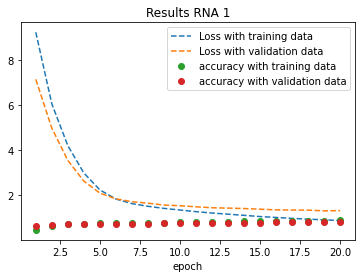

In [110]:
# visualizamos resultados:

history_dict = results.history  # <-- extrae en 'accuracy' y 'loss' de cada 'epoch'
# history_dict = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...] }

loss_values = history_dict['loss']# <-- valores del 'loss'
val_loss_values = history_dict['val_loss'] #<-- valores del 'loss' (para datos de validacion)
accuracy_values = history_dict['accuracy']# <-- valores del 'loss'
val_accuracy_values = history_dict['val_accuracy'] #<-- valores del 'loss' (para datos de validacion)

# numeramos 'epochs' contando desde 1:
epoch = range(1,len(loss_values)+1)

# Normalizamos 'loss':
#loss_values = loss_values/np.max(loss_values)
#val_loss_values = val_loss_values/np.max(val_loss_values)

plt.figure()
plt.plot(epoch, loss_values, '--', label='Loss with training data')
plt.plot(epoch, val_loss_values, '--', label='Loss with validation data')
plt.plot(epoch, accuracy_values, 'o', label='accuracy with training data')
plt.plot(epoch, val_accuracy_values, 'o', label='accuracy with validation data')
plt.legend()
plt.title('Results RNA 1')
plt.xlabel('epoch')
plt.show()

## Obtenemos valores de error y precisión usando los datos de prueba (desconocidos por la red):

In [111]:
# medimos precisión del entrenamiento con los datos de prueba:
model.evaluate(x_test,y_test)

71/71 [==============================] - 0s 2ms/step - loss: 1.3399 - accuracy: 0.7689


[1.3398889303207397, 0.7689225077629089]

## Hacemos predicciones con el modelo entrenado:

In [112]:
# Predecimos las etiquetas de todos los features de prueba: 
y_predict = model.predict(x_test)

y_predict.shape

(2246, 46)

In [113]:
# Predecimos una etiqueta en particular:

i = 1571 #<--- indice del valor a predecir (< 2246)

label_obs  = labels_test[i] #np.argmax(y_test[i])
label_aprx = np.argmax(y_predict[i])

print('    Etiqueta real: ', label_obs )
print('Etiqueta predicha: ', label_aprx )

    Etiqueta real:  4
Etiqueta predicha:  4
